## Forecasting, updating datasets, and the "news"

In this notebook, we describe how to use Statsmodels to compute the impacts of updated or revised datasets on out-of-sample forecasts or in-sample estimates of missing data. We follow the approach of the "Nowcasting" literature (see references at the end), by using a state space model to compute the "news" and impacts of incoming data.

**Note**: this notebook applies to Statsmodels v0.12+. In addition, it only applies to the state space models or related classes, which are: `sm.tsa.statespace.ExponentialSmoothing`, `sm.tsa.arima.ARIMA`, `sm.tsa.SARIMAX`, `sm.tsa.UnobservedComponents`, `sm.tsa.VARMAX`, and `sm.tsa.DynamicFactor`.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

macrodata = sm.datasets.macrodata.load_pandas().data
macrodata.index = pd.period_range('1959Q1', '2009Q3', freq='Q')

Forecasting exercises often start with a fixed set of historical data that is used for model selection and parameter estimation. Then, the fitted selected model (or models) can be used to create out-of-sample forecasts. Most of the time, this is not the end of the story. As new data comes in, you may need to evaluate your forecast errors, possibly update your models, and create updated out-of-sample forecasts. This is sometimes called a "real-time" forecasting exercise (by contrast, a pseudo real-time exercise is one in which you simulate this procedure).

If all that matters is minimizing some loss function based on forecast errors (like MSE), then when new data comes in you may just want to completely redo model selection, parameter estimation and out-of-sample forecasting, using the updated datapoints. If you do this, your new forecasts will have changed for two reasons:

1. You have received new data that gives you new information
2. Your forecasting model or the estimated parameters are different

In this notebook, we focus on methods for isolating the first effect. The way we do this comes from the so-called "nowcasting" literature, and in particular Bańbura, Giannone, and Reichlin (2011), Bańbura and Modugno (2014), and Bańbura et al. (2014). They describe this exercise as computing the "**news**", and we follow them in using this language in Statsmodels.

These methods are perhaps most useful with multivariate models, since there multiple variables may update at the same time, and it is not immediately obvious what forecast change was created by what updated variable. However, they can still be useful for thinking about forecast revisions in univariate models. We will therefore start with the simpler univariate case to explain how things work, and then move to the multivariate case afterwards.

**Note on revisions**: the framework that we are using is designed to decompose changes to forecasts from newly observed datapoints. It can also take into account *revisions* to previously published datapoints, but it does not decompose them separately. Instead, it only shows the aggregate effect of "revisions".

**Note on `exog` data**: the framework that we are using only decomposes changes to forecasts from newly observed datapoints for *modeled* variables. These are the "left-hand-side" variables that in Statsmodels are given in the `endog` arguments. This framework does not decompose or account for changes to unmodeled "right-hand-side" variables, like those included in the `exog` argument.

### Simple univariate example: AR(1)

We will begin with a simple autoregressive model, an AR(1):

$$y_t = \phi y_{t-1} + \varepsilon_t$$

- The parameter $\phi$ captures the persistence of the series

We will use this model to forecast inflation.

To make it simpler to describe the forecast updates in this notebook, we will work with inflation data that has been de-meaned, but it is straightforward in practice to augment the model with a mean term.


In [2]:
# De-mean the inflation series
y = macrodata['infl'] - macrodata['infl'].mean()

#### Step 1: fitting the model on the available dataset

Here, we'll simulate an out-of-sample exercise, by constructing and fitting our model using all of the data except the last five observations. We'll assume that we haven't observed these values yet, and then in subsequent steps we'll add them back into the analysis.

<AxesSubplot:title={'center':'Inflation'}>

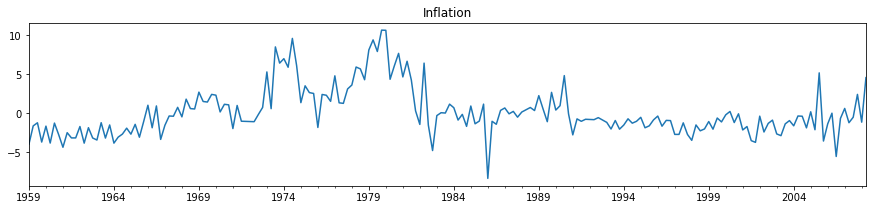

In [3]:
y_pre = y.iloc[:-5]
y_pre.plot(figsize=(15, 3), title='Inflation');

To construct forecasts, we first estimate the parameters of the model. This returns a results object that we will be able to use produce forecasts.

In [4]:
mod_pre = sm.tsa.arima.ARIMA(y_pre, order=(1, 0, 0), trend='n')
res_pre = mod_pre.fit()
print(res_pre.summary())

                               SARIMAX Results                                
Dep. Variable:                   infl   No. Observations:                  198
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -446.407
Date:                Tue, 02 Feb 2021   AIC                            896.813
Time:                        06:52:07   BIC                            903.390
Sample:                    03-31-1959   HQIC                           899.475
                         - 06-30-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6751      0.043     15.858      0.000       0.592       0.759
sigma2         5.3027      0.367     14.459      0.000       4.584       6.022
Ljung-Box (L1) (Q):                  15.65   Jarque-

Creating the forecasts from the results object `res` is easy - you can just call the `forecast` method with the number of forecasts you want to construct. In this case, we'll construct four out-of-sample forecasts.

<AxesSubplot:>

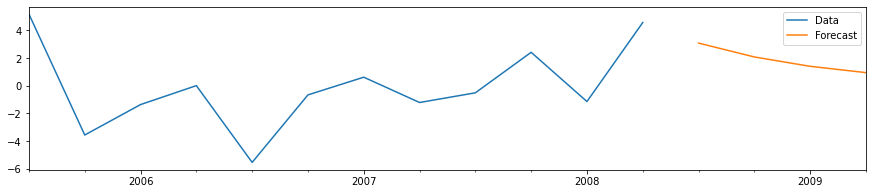

In [5]:
# Compute the forecasts
forecasts_pre = res_pre.forecast(4)

# Plot the last 3 years of data and the four out-of-sample forecasts
y_pre.iloc[-12:].plot(figsize=(15, 3), label='Data', legend=True)
forecasts_pre.plot(label='Forecast', legend=True);

For the AR(1) model, it is also easy to manually construct the forecasts. Denoting the last observed variable as $y_T$ and the $h$-step-ahead forecast as $y_{T+h|T}$, we have:

$$y_{T+h|T} = \hat \phi^h y_T$$

Where $\hat \phi$ is our estimated value for the AR(1) coefficient. From the summary output above, we can see that this is the first parameter of the model, which we can access from the `params` attribute of the results object.

In [6]:
# Get the estimated AR(1) coefficient
phi_hat = res_pre.params[0]

# Get the last observed value of the variable
y_T = y_pre.iloc[-1]

# Directly compute the forecasts at the horizons h=1,2,3,4
manual_forecasts = pd.Series([phi_hat * y_T, phi_hat**2 * y_T,
                              phi_hat**3 * y_T, phi_hat**4 * y_T],
                             index=forecasts_pre.index)

# We'll print the two to double-check that they're the same
print(pd.concat([forecasts_pre, manual_forecasts], axis=1))

        predicted_mean         0
2008Q3        3.084388  3.084388
2008Q4        2.082323  2.082323
2009Q1        1.405812  1.405812
2009Q2        0.949088  0.949088


#### Step 2: computing the "news" from a new observation

Suppose that time has passed, and we have now received another observation. Our dataset is now larger, and we can evaluate our forecast error and produce updated forecasts for the subsequent quarters.

In [7]:
# Get the next observation after the "pre" dataset
y_update = y.iloc[-5:-4]

# Print the forecast error
print('Forecast error: %.2f' % (y_update.iloc[0] - forecasts_pre.iloc[0]))

Forecast error: -10.21


To compute forecasts based on our updated dataset, we will create an updated results object `res_post` using the `append` method, to append on our new observation to the previous dataset.

Note that by default, the `append` method does not re-estimate the parameters of the model. This is exactly what we want here, since we want to isolate the effect on the forecasts of the new information only.

In [8]:
# Create a new results object by passing the new observations to the `append` method
res_post = res_pre.append(y_update)

# Since we now know the value for 2008Q3, we will only use `res_post` to
# produce forecasts for 2008Q4 through 2009Q2
forecasts_post = pd.concat([y_update, res_post.forecast('2009Q2')])
print(forecasts_post)

2008Q3   -7.121330
2008Q4   -4.807732
2009Q1   -3.245783
2009Q2   -2.191284
Freq: Q-DEC, dtype: float64


In this case, the forecast error is quite large - inflation was more than 10 percentage points below the AR(1) models' forecast. (This was largely because of large swings in oil prices around the global financial crisis).

To analyse this in more depth, we can use Statsmodels to isolate the effect of the new information - or the "**news**" - on our forecasts. This means that we do not yet want to change our model or re-estimate the parameters. Instead, we will use the `news` method that is available in the results objects of state space models.

Computing the news in Statsmodels always requires a *previous* results object or dataset, and an *updated* results object or dataset. Here we will use the original results object `res_pre` as the previous results and the `res_post` results object that we just created as the updated results.

Once we have previous and updated results objects or datasets, we can compute the news by calling the `news` method. Here, we will call `res_pre.news`, and the first argument will be the updated results, `res_post` (however, if you have two results objects, the `news` method could can be called on either one).

In addition to specifying the comparison object or dataset as the first argument, there are a variety of other arguments that are accepted. The most important specify the "impact periods" that you want to consider. These "impact periods" correspond to the forecasted periods of interest; i.e. these dates specify with periods will have forecast revisions decomposed.

To specify the impact periods, you must pass two of `start`, `end`, and `periods` (similar to the Pandas `date_range` method). If your time series was a Pandas object with an associated date or period index, then you can pass dates as values for `start` and `end`, as we do below.

In [9]:
# Compute the impact of the news on the four periods that we previously
# forecasted: 2008Q3 through 2009Q2
news = res_pre.news(res_post, start='2008Q3', end='2009Q2')
# Note: one alternative way to specify these impact dates is
# `start='2008Q3', periods=4`

The variable `news` is an object of the class `NewsResults`, and it contains details about the updates to the data in `res_post` compared to `res_pre`, the new information in the updated dataset, and the impact that the new information had on the forecasts in the period between `start` and `end`.

One easy way to summarize the results are with the `summary` method.

In [10]:
print(news.summary())

                                     News                                     
Model:                          ARIMA   Original sample:                1959Q1
Date:                Tue, 02 Feb 2021                                 - 2008Q2
Time:                        06:52:07   Update through:                 2008Q3
                                        No. Revisions:                       0
                                        No. New datapoints:                  1
          Impacts for [impacted variable = infl]         
impact date estimate (prev) impact of news estimate (new)
---------------------------------------------------------
     2008Q3            3.08         -10.21          -7.12
     2008Q4            2.08          -6.89          -4.81
     2009Q1            1.41          -4.65          -3.25
     2009Q2            0.95          -3.14          -2.19
                  News from updated observations:                  
update date updated variable   observed forecast (pr

**Summary output**: the default summary for this news results object printed four tables:

1. Summary of the model and datasets
2. Details of the news from updated data
3. Summary of the impacts of the new information on the forecasts between `start='2008Q3'` and `end='2009Q2'`
4. Details of how the updated data led to the impacts on the forecasts between `start='2008Q3'` and `end='2009Q2'`

These are described in more detail below.

*Notes*:

- There are a number of arguments that can be passed to the `summary` method to control this output. Check the documentation / docstring for details.
- Table (4), showing details of the updates and impacts, can become quite large if the model is multivariate, there are multiple updates, or a large number of impact dates are selected. It is only shown by default for univariate models.

**First table: summary of the model and datasets**

The first table, above, shows:

- The type of model from which the forecasts were made. Here this is an ARIMA model, since an AR(1) is a special case of an ARIMA(p,d,q) model.
- The date and time at which the analysis was computed.
- The original sample period, which here corresponds to `y_pre`
- The endpoint of the updated sample period, which here is the last date in `y_post`

**Second table: the news from updated data**

This table simply shows the forecasts from the previous results for observations that were updated in the updated sample.

*Notes*:

- Our updated dataset `y_post` did not contain any *revisions* to previously observed datapoints. If it had, there would be an additional table showing the previous and updated values of each such revision.

**Third table: summary of the impacts of the new information**

*Columns*:

The third table, above, shows:

- The previous forecast for each of the impact dates, in the "estimate (prev)" column
- The impact that the new information (the "news") had on the forecasts for each of the impact dates, in the "impact of news" column
- The updated forecast for each of the impact dates, in the "estimate (new)" column

*Notes*:

- In multivariate models, this table contains additional columns describing the relevant impacted variable for each row.
- Our updated dataset `y_post` did not contain any *revisions* to previously observed datapoints. If it had, there would be additional columns in this table showing the impact of those revisions on the forecasts for the impact dates.
- Note that `estimate (new) = estimate (prev) + impact of news`
- This table can be accessed independently using the `summary_impacts` method.

*In our example*:

Notice that in our example, the table shows the values that we computed earlier:

- The "estimate (prev)" column is identical to the forecasts from our previous model, contained in the `forecasts_pre` variable.
- The "estimate (new)" column is identical to our `forecasts_post` variable, which contains the observed value for 2008Q3 and the forecasts from the updated model for 2008Q4 - 2009Q2.

**Fourth table: details of updates and their impacts**

The fourth table, above, shows how each new observation translated into specific impacts at each impact date.

*Columns*:

The first three columns table described the relevant **update** (an "updated" is a new observation):

- The first column ("update date") shows the date of the variable that was updated.
- The second column ("forecast (prev)") shows the value that would have been forecasted for the update variable at the update date based on the previous results / dataset.
- The third column ("observed") shows the actual observed value of that updated variable / update date in the updated results / dataset.

The last four columns described the **impact** of a given update (an impact is a changed forecast within the "impact periods").

- The fourth column ("impact date") gives the date at which the given update made an impact.
- The fifth column ("news") shows the "news" associated with the given update (this is the same for each impact of a given update, but is just not sparsified by default)
- The sixth column ("weight") describes the weight that the "news" from the given update has on the impacted variable at the impact date. In general, weights will be different between each "updated variable" / "update date" / "impacted variable" / "impact date" combination.
- The seventh column ("impact") shows the impact that the given update had on the given "impacted variable" / "impact date".

*Notes*:

- In multivariate models, this table contains additional columns to show the relevant variable that was updated and variable that was impacted for each row. Here, there is only one variable ("infl"), so those columns are suppressed to save space.
- By default, the updates in this table are "sparsified" with blanks, to avoid repeating the same values for "update date", "forecast (prev)", and "observed" for each row of the table. This behavior can be overridden using the `sparsify` argument.
- Note that `impact = news * weight`.
- This table can be accessed independently using the `summary_details` method.

*In our example*:

- For the update to 2008Q3 and impact date 2008Q3, the weight is equal to 1. This is because we only have one variable, and once we have incorporated the data for 2008Q3, there is no no remaining ambiguity about the "forecast" for this date. Thus all of the "news" about this variable at 2008Q3 passes through to the "forecast" directly.

#### Addendum: manually computing the news, weights, and impacts

For this simple example with a univariate model, it is straightforward to compute all of the values shown above by hand. First, recall the formula for forecasting $y_{T+h|T} = \phi^h y_T$, and note that it follows that we also have $y_{T+h|T+1} = \phi^h y_{T+1}$. Finally, note that $y_{T|T+1} = y_T$, because if we know the value of the observations through $T+1$, we know the value of $y_T$.

**News**: The "news" is nothing more than the forecast error associated with one of the new observations. So the news associated with observation $T+1$ is:

$$n_{T+1} = y_{T+1} - y_{T+1|T} = Y_{T+1} - \phi Y_T$$

**Impacts**: The impact of the news is the difference between the updated and previous forecasts, $i_h \equiv y_{T+h|T+1} - y_{T+h|T}$.

- The previous forecasts for $h=1, \dots, 4$ are: $\begin{pmatrix} \phi y_T & \phi^2 y_T & \phi^3 y_T & \phi^4 y_T \end{pmatrix}'$. 
- The updated forecasts for $h=1, \dots, 4$ are: $\begin{pmatrix} y_{T+1} & \phi y_{T+1} & \phi^2 y_{T+1} & \phi^3 y_{T+1} \end{pmatrix}'$.

The impacts are therefore:

$$\{ i_h \}_{h=1}^4 = \begin{pmatrix} y_{T+1} - \phi y_T \\ \phi (Y_{T+1} - \phi y_T) \\ \phi^2 (Y_{T+1} - \phi y_T) \\ \phi^3 (Y_{T+1} - \phi y_T) \end{pmatrix}$$

**Weights**: To compute the weights, we just need to note that it is immediate that we can rewrite the impacts in terms of the forecast errors, $n_{T+1}$.

$$\{ i_h \}_{h=1}^4 = \begin{pmatrix} 1 \\ \phi \\ \phi^2 \\ \phi^3 \end{pmatrix} n_{T+1}$$

The weights are then simply $w = \begin{pmatrix} 1 \\ \phi \\ \phi^2 \\ \phi^3 \end{pmatrix}$

We can check that this is what the `news` method has computed.

In [11]:
# Print the news, computed by the `news` method
print(news.news)

# Manually compute the news
print()
print((y_update.iloc[0] - phi_hat * y_pre.iloc[-1]).round(6))

update date  updated variable
2008Q3       infl               -10.205718
Name: news, dtype: float64

-10.205718


In [12]:
# Print the total impacts, computed by the `news` method
# (Note: news.total_impacts = news.revision_impacts + news.update_impacts, but
# here there are no data revisions, so total and update impacts are the same)
print(news.total_impacts)

# Manually compute the impacts
print()
print(forecasts_post - forecasts_pre)

             infl
2008Q3 -10.205718
2008Q4  -6.890055
2009Q1  -4.651595
2009Q2  -3.140371

2008Q3   -10.205718
2008Q4    -6.890055
2009Q1    -4.651595
2009Q2    -3.140371
Freq: Q-DEC, dtype: float64


In [13]:
# Print the weights, computed by the `news` method
print(news.weights)

# Manually compute the weights
print()
print(np.array([1, phi_hat, phi_hat**2, phi_hat**3]).round(6))

impact date                  2008Q3    2008Q4    2009Q1    2009Q2
impacted variable              infl      infl      infl      infl
update date updated variable                                     
2008Q3      infl                1.0  0.675117  0.455783  0.307707

[1.       0.675117 0.455783 0.307707]


### Multivariate example: dynamic factor

In this example, we'll consider forecasting monthly core price inflation based on the Personal Consumption Expenditures (PCE) price index and the Consumer Price Index (CPI), using a Dynamic Factor model. Both of these measures track prices in the US economy and are based on similar source data, but they have a number of definitional differences. Nonetheless, they track each other relatively well, so modeling them jointly using a single dynamic factor seems reasonable.

One reason that this kind of approach can be useful is that the CPI is released earlier in the month than the PCE. One the CPI is released, therefore, we can update our dynamic factor model with that additional datapoint, and obtain an improved forecast for that month's PCE release. A more involved version of this kind of analysis is available in Knotek and Zaman (2017).

We start by downloading the core CPI and PCE price index data from [FRED](https://fred.stlouisfed.org/), converting them to annualized monthly inflation rates, removing two outliers, and de-meaning each series (the dynamic factor model does not 

In [14]:
import pandas_datareader as pdr
levels = pdr.get_data_fred(['PCEPILFE', 'CPILFESL'], start='1999', end='2019').to_period('M')
infl = np.log(levels).diff().iloc[1:] * 1200
infl.columns = ['PCE', 'CPI']

# Remove two outliers and de-mean the series
infl['PCE'].loc['2001-09':'2001-10'] = np.nan

To show how this works, we'll imagine that it is April 14, 2017, which is the data of the March 2017 CPI release. So that we can show the effect of multiple updates at once, we'll assume that we haven't updated our data since the end of January, so that:

- Our **previous dataset** will consist of all values for the PCE and CPI through January 2017
- Our **updated dataset** will additionally incorporate the CPI for February and March 2017 and the PCE data for February 2017. But it will not yet the PCE (the March 2017 PCE price index was not released until May 1, 2017).

In [15]:
# Previous dataset runs through 2017-02
y_pre = infl.loc[:'2017-01'].copy()
const_pre = np.ones(len(y_pre))
print(y_pre.tail())

              PCE       CPI
DATE                       
2016-09  1.149555  1.631931
2016-10  1.879740  1.730896
2016-11  0.730840  2.089176
2016-12  1.550156  2.195968
2017-01  3.083120  2.685434


In [16]:
# For the updated dataset, we'll just add in the
# CPI value for 2017-03
y_post = infl.loc[:'2017-03'].copy()
y_post.loc['2017-03', 'PCE'] = np.nan
const_post = np.ones(len(y_post))

# Notice the missing value for PCE in 2017-03
print(y_post.tail())

              PCE       CPI
DATE                       
2016-11  0.730840  2.089176
2016-12  1.550156  2.195968
2017-01  3.083120  2.685434
2017-02  1.790177  2.239655
2017-03       NaN -0.444727


We chose this particular example because in March 2017, core CPI prices fell for the first time since 2010, and this information may be useful in forecast core PCE prices for that month. The graph below shows the CPI and PCE price data as it would have been observed on April 14th$^\dagger$.

-----

$\dagger$ This statement is not entirely true, because both the CPI and PCE price indexes can be revised to a certain extent after the fact. As a result, the series that we're pulling are not exactly like those observed on April 14, 2017. This could be fixed by pulling the archived data from [ALFRED](https://alfred.stlouisfed.org/) instead of [FRED](https://fred.stlouisfed.org/), but the data we have is good enough for this tutorial.

(468.0, 569.0)

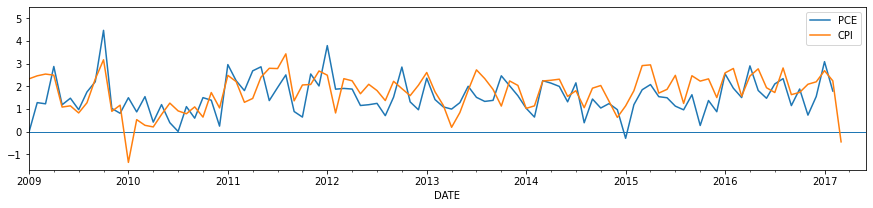

In [17]:
# Plot the updated dataset
fig, ax = plt.subplots(figsize=(15, 3))
y_post.plot(ax=ax)
ax.hlines(0, '2009', '2017-06', linewidth=1.0)
ax.set_xlim('2009', '2017-06');

To perform the exercise, we first construct and fit a `DynamicFactor` model. Specifically:

- We are using a single dynamic factor (`k_factors=1`)
- We are modeling the factor's dynamics with an AR(6) model (`factor_order=6`)
- We have included a vector of ones as an exogenous variable (`exog=const_pre`), because the inflation series we are working with are not mean-zero.

In [18]:
mod_pre = sm.tsa.DynamicFactor(y_pre, exog=const_pre, k_factors=1, factor_order=6)
res_pre = mod_pre.fit()
print(res_pre.summary())

                                   Statespace Model Results                                  
Dep. Variable:                        ['PCE', 'CPI']   No. Observations:                  216
Model:             DynamicFactor(factors=1, order=6)   Log Likelihood                -514.952
                                      + 1 regressors   AIC                           1053.905
Date:                               Tue, 02 Feb 2021   BIC                           1094.408
Time:                                       06:52:12   HQIC                          1070.268
Sample:                                   02-28-1999                                         
                                        - 01-31-2017                                         
Covariance Type:                                 opg                                         
Ljung-Box (L1) (Q):             2.13, 0.35   Jarque-Bera (JB):          17.17, 6.27
Prob(Q):                        0.14, 0.55   Prob(JB):                

With the fitted model in hand, we now construct the news and impacts associated with observing the CPI for March 2017. The updated data is for February 2017 and part of March 2017, and we'll examining the impacts on both March and April.

In the univariate example, we first created an updated results object, and then passed that to the `news` method. Here, we're creating the news by directly passing the updated dataset.

Notice that:

1. `y_post` contains the entire updated dataset (not just the new datapoints)
2. We also had to pass an updated `exog` array. This array must cover **both**:
    - The entire period associated with `y_post`
    - Any additional datapoints after the end of `y_post` through the last impact date, specified by `end`

   Here, `y_post` ends in March 2017, so we needed our `exog` to extend one more period, to April 2017.

In [19]:
# Create the news results
# Note
const_post_plus1 = np.ones(len(y_post) + 1)
news = res_pre.news(y_post, exog=const_post_plus1, start='2017-03', end='2017-04')

> **Note**:
>
> In the univariate example, above, we first constructed a new results object, and then passed that to the `news` method. We could have done that here too, although there is an extra step required. Since we are requesting an impact for a period beyond the end of `y_post`, we would still need to pass the additional value for the `exog` variable during that period to `news`:
> 
> ```python
res_post = res_pre.apply(y_post, exog=const_post)
news = res_pre.news(res_post, exog=[1.], start='2017-03', end='2017-04')
```

Now that we have computed the `news`, printing `summary` is a convenient way to see the results.

In [20]:
# Show the summary of the news results
print(news.summary())

                                     News                                     
Model:                  DynamicFactor   Original sample:               1999-02
Date:                Tue, 02 Feb 2021                                - 2017-01
Time:                        06:52:12   Update through:                2017-04
                                        No. Revisions:                       0
                                        No. New datapoints:                  3
                                  Impacts                                  
impact date impacted variable estimate (prev) impact of news estimate (new)
---------------------------------------------------------------------------
    2017-03               CPI            2.04          -2.48          -0.44
                          PCE            1.74          -1.48           0.26
    2017-04               CPI            2.00          -0.29           1.72
                          PCE            1.72          -0.17          

Because we have multiple variables, by default the summary only shows the news from updated data along and the total impacts.

From the first table, we can see that our updated dataset contains three new data points, with most of the "news" from these data coming from the very low reading in March 2017.

The second table shows that these three datapoints substantially impacted the estimate for PCE in March 2017 (which was not yet observed). This estimate revised down by nearly 1.5 percentage points.

The updated data also impacted the forecasts in the first out-of-sample month, April 2017. After incorporating the new data, the model's forecasts for CPI and PCE inflation in that month revised down 0.29 and 0.17 percentage point, respectively.

While these tables show the "news" and the total impacts, they do not show how much of each impact was caused by each updated datapoint. To see that information, we need to look at the details tables.

One way to see the details tables is to pass `include_details=True` to the `summary` method. To avoid repeating the tables above, however, we'll just call the `summary_details` method directly.

In [21]:
print(news.summary_details())

                                                       Details                                                        
update date updated variable   observed forecast (prev) impact date impacted variable       news     weight     impact
----------------------------------------------------------------------------------------------------------------------
    2017-02              CPI       2.24            2.19     2017-03               CPI       0.05       0.00          0
                                                                                  PCE       0.05       0.00          0
                                                            2017-04               CPI       0.05       0.18       0.01
                                                                                  PCE       0.05       0.11       0.01
                         PCE       1.79            1.83                           CPI      -0.04       0.00          0
                                                

This table shows that most of the revisions to the estimate of PCE in April 2017, described above, came from the news associated with the CPI release in March 2017. By contrast, the CPI release in February had only a little effect on the April forecast, and the PCE release in February had essentially no effect.

### Bibliography

Bańbura, Marta, Domenico Giannone, and Lucrezia Reichlin. "Nowcasting." The Oxford Handbook of Economic Forecasting. July 8, 2011.

Bańbura, Marta, Domenico Giannone, Michele Modugno, and Lucrezia Reichlin. "Now-casting and the real-time data flow." In Handbook of economic forecasting, vol. 2, pp. 195-237. Elsevier, 2013.

Bańbura, Marta, and Michele Modugno. "Maximum likelihood estimation of factor models on datasets with arbitrary pattern of missing data." Journal of Applied Econometrics 29, no. 1 (2014): 133-160.

Knotek, Edward S., and Saeed Zaman. "Nowcasting US headline and core inflation." Journal of Money, Credit and Banking 49, no. 5 (2017): 931-968.